# Agent1 - Planner Agent

## State
Trip Preferences
- duration
- target_area
- themes
- intensity
- companions
- transport
- is_complete
- missing_info_question
- additional_notes

## Agent State
- Messages
- Preferences

In [ ]:
import operator
from typing import TypedDict, Annotated, List, Optional, Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import json
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph, END, START, MessagesState

# Agent가 채워 넣어야 할 데이터 구조 정의
# --- 1. Agent 1 데이터 스키마 (TripPreferences) ---
class TripPreferences(BaseModel):
    # 1. 기간
    duration: int = Field(
        None,
        description="여행 기간. 예: '1', '2', '3' 등 체류할 기간을 숫자로 명시한다. 1박 2일이면 2일을 체류하기 때문에 2를 저장한다. 몇 박 묵을지는 궁금하지 않다. 명시되지 않으면 None."
    )

    # 2. 여행 지역 (여기에 추가!)
    target_area: Optional[str] = Field(
        default=None,
        description="구체적인 서울의 여행 지역. 예: '종로구', '성수동', '강남', '홍대', '잠실'. 명시되지 않으면 None."
    )

    # 3. 테마 (여러 개일 수 있으니 List로)
    themes: List[Literal['맛집', '쇼핑', '문화/예술', '힐링', '체험/액티비티', '뷰/야경', '트렌드']] = Field(
        default_factory=list,
        description="여행 테마 리스트. 사용자의 입력에서 유추할 수 있는 **모든** 테마를 전부 선택하세요. 하나만 선택하지 말고, 해당되는 것은 다 포함시키세요."
    )

    # 4. 강도 (숫자로 변환)
    intensity: int = Field(
        None,
        description="여행 강도 (0~100). 0은 완전한 휴식, 100은 빡빡한 일정. 강도를 단순히 0, 50, 100으로 나누지 말고, 사용자의 입력을 분석한 뒤 적절한 값으로 반환합니다. 정보가 없으면 None"
    )
    
    # 5. 동행자
    companions: Optional[Literal['혼자', '친구', '연인', '가족(아이)', '가족(부모님)']] = Field(
        None,
        description="동행자 유형. 예: '혼자', '친구', '연인', '가족(아이)', '가족(부모님)'. 정보가 없으면 None"
    )
    
    # 6. 이동 방식
    transport: Optional[Literal['대중교통', '도보', '차량']] = Field(
        None,
        description="이동 수단 선호. 사용자의 입력에서 유추할 수 있는 **모든** 테마를 전부 선택하세요. 하나만 선택하지 말고, 해당되는 것은 다 포함시키세요. 정보가 없다면 None"
    )

    # 7. HITL 필수 필드 (대화 제어용)
    is_complete: bool = Field(
        False,
        description="위 6가지 필수 정보(duration, themes, intensity, companions, transport, target_area)가 모두 채워졌는지 여부."
    )
    
    # 8. 부족한 부분을 채우기 위한 질문지
    missing_info_question: Optional[str] = Field(
        None, 
        description="정보가 부족할 경우 사용자에게 던질 질문. (부족한 항목을 콕 집어서 질문)"
    )

    # 9. 기타 (혹시 모를 추가 요청사항)
    additional_notes: Optional[str] = Field(
        None,
        description="""
        사용자의 여행 계획을 요약한 '종합 브리핑'입니다. 다음 두 가지 내용을 자연스러운 줄글로 통합하여 작성하세요.
        1. [요약]: 추출된 5가지 필수 정보(누구와, 기간, 테마, 강도, 이동수단)를 포함하여 여행의 전체 그림을 서술.
        2. [맥락]: 위 5가지 카테고리에 딱 들어맞지 않는 구체적인 요구사항이나 제약조건(예: '다리가 아파요', '매운 음식 못 먹어요', '특정 유튜버 맛집')도 빠짐없이 포함.
        ※ 정보가 부족하다면, 현재까지 파악된 내용만으로 요약합니다.
        """
    )

    # 10. 사용자의 사용 언어
    language: str = Field(
        None,
        description="사용자가 입력한 언어(한/영/일/중 등)를 감지하세요. 그리고 해당 언어를 영어로 작성합니다. 예: Korean"
    )


class AgentState(TypedDict):
    # 입력: 사용자의 질문
    messages: Annotated[List[BaseMessage], operator.add]

    # 출력: Agent 1이 채워넣을 분석 결과 (초기에는 None일 수 있음)
    preferences: TripPreferences
    
    
def planner_node(state: AgentState):
   print("🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---")
   
   # 2. LLM 설정 (구조화된 출력)
   llm = ChatOpenAI(model='gpt-4.1-mini', temperature=0)
   structured_llm = llm.with_structured_output(TripPreferences)

   # 현재 상태 가져오기
   current_pref = state.get("preferences", TripPreferences())

   # 시스템 프롬프트: "5가지가 다 모여야 탈출 가능"
   system_prompt = f"""
   당신은 한국어, 영어, 일본어, 중국어에 모두 능통한 '베테랑 여행 플래너'입니다.
   사용자의 입력과 대화 내역을 분석하여 여행 정보를 추출하세요.
   
   [현재 파악된 정보]
   {json.dumps(current_pref.model_dump(), indent=2, ensure_ascii=False)}
   
   [필수 확보 정보 (5-Check)]
   여행 계획을 짜기 위해 다음 5가지 정보는 **반드시** 값이 있어야 합니다.
   1. duration (기간)
   2. target_area (여행 지역 - 예: 종로, 성수, 강남 등)
   3. themes (테마 - 최소 1개 이상)
   4. intensity (여행 강도)
   5. companions (동행자)
   6. transport (이동 수단)

   [언어 처리 규칙 (매우 중요)]
   1. **언어 감지**: 사용자가 입력한 언어(한/영/일/중 등)를 감지하세요.
   2. **데이터 매핑 (Internal)**: 사용자가 외국어로 말하더라도, 추출하는 값은 반드시 스키마에 정의된 **'한국어 표준 값'**으로 변환하여 저장하세요.
      - 예: User "I want to go shopping" -> themes=['쇼핑'] (NOT 'Shopping')
      - 예: User "電車で行きます (전철로 갈래요)" -> transport='대중교통'
   3. **질문 생성 (External)**: `missing_info_question`은 반드시 **사용자가 입력한 언어**로 작성하세요.
      - 예: 사용자가 일본어로 말했으면, 질문도 일본어로 생성.
   
   [지시사항]
   - 위 6가지 중 하나라도 값이 없거나(None), 빈 리스트라면 'is_complete'는 False입니다.
   - 'is_complete'가 False라면, 부족한 정보가 무엇인지 파악하여 사용자에게 자연스럽게 물어보는 질문을 'missing_info_question'에 작성하세요.
   - **특히 '지역(target_area)'이 없다면, "서울의 어느 동네를 보고 싶으신가요? (예: 종로, 성수, 강남)" 하고 물어보세요.**
   - 만약 사용자가 "잘 모르겠어요"라고 하면, 테마를 보고 추천해주지 말고 "추천해드릴까요?"라고 되물어서 지역을 확정 짓도록 유도하세요.
   - **질문은 친절하고 정중한 톤을 유지하세요.**
   - 모든 정보가 채워졌을 때만 'is_complete'를 True로 설정하세요.
   """

   messages = [SystemMessage(content=system_prompt)] + state["messages"]
   
   result = structured_llm.invoke(messages)
   
   return {"preferences": result}

# Agent2 - Theme allocator
## State
CategoryAllocation
- category_group_code
- keywords
- count
- weight
- reason

ItineraryStrategy
- CategoryAllocation

## Agent State [Updated!]
- Messages
- Preferences
- strategy

In [ ]:
# Kakao Local API 코드 기반 할당
class CategoryAllocation(BaseModel):
    category_group_code: Literal[
        'FD6', 'CE7', 'CT1', 'AT4', 'AD5', # 핵심 (식음료, 관광, 숙박)
        'PK6', 'OL7', 'SW8',               # 교통 (주차, 주유, 지하철)
        'MT1', 'CS2'                       # 편의 (마트, 편의점)
        # HP8(병원), PM9(약국) 등은 특수 상황 아니면 제외 (필요시 추가 가능)
    ] = Field(
            description = "Kakao Map API의 카테고리 그룹 코드(MT1:대형마트, CS2:편의점, PS3:어린이집, 유치원, SC4:학교, AC5:학원, PK6:주차장, OL7:주유소, 충전소, SW8:지하철역, BK9:은행, CT1:문화시설, AG2:중개업소, PO3:공공기관, AT4:관광명소, AD5:숙박, FD6:음식점, CE7:카페, HP8:병원, PM9:약국)"
    )
    
    keywords: List[str] = Field(
        description="인터넷 검색할 때 필요한 구체적인 키워드 리스트. Agent 1이 정한 지역명을 포함해서 작성한다."
    )

    count: int = Field(description="필요한 장소의 개수. 하루에 방문할 만한 최대 횟수를 기록한다. (여행 기간에 비례)") # 수정

    weight: int = Field(description="검색 우선순위 가중치 (1~10). 점수가 높을수록 '여행의 메인 목적'이며, 먼저 검색되어 기준점(Anchor)이 됩니다.") # 수정

    reason: str = Field(
        description="해당 category_group_code들을 선택한 이유"
    )

class ItineraryStrategy(BaseModel):
    allocations: List[CategoryAllocation] = Field(
        description="카테고리 코드별 할당 리스트"
    )
# MessageState를 넣으면, MessageState안에 messages가 있다.
# id - Memory ?
# Memory를 따로 선언하지 않아도, TypeDict가 아닌 MessageState로 하는 경우에는 알아서 저장이 됨.
# HumanMessage랑 AI Message가 생긴다.
# Interrupt 걸면 Node를 다시 실행한다. HITL의 경우에, message가 대체되어야 하는데... (왜지- 동일한 노드를 동일한 메시지로 다시 실행시키기 때문)

# class AgentState(MessageState): 나중에 해보기
class AgentState(TypedDict):
    # 1. 대화 기록 (공통)
    messages: Annotated[List[BaseMessage], operator.add]

    # 2. Agent 1의 결과물 (User Preferences)
    preferences: Optional[TripPreferences]

    # 3. Agent 2의 결과물 (Search Strategy)
    strategy: Optional[ItineraryStrategy]

def allocator_node(state: AgentState):
   print("\n⚖️ --- [Agent 2] Kakao 코드 기반 할당 전략 수립 중 ---")

   # Agent 1의 결과 (TripPreferences)
   preferences = state['preferences']
   target_area = preferences.target_area
   duration = preferences.duration
   # 수정사항
   # 지금은 모든 node에서 llm을 ? 하고 있는데, 이걸 global로 변경할 필요는 있다.
   
   llm = ChatOpenAI(model='gpt-4.1-mini', temperature=0)
   structured_llm = llm.with_structured_output(ItineraryStrategy)

   system_prompt = f"""
   당신은 치밀한 여행 전략가입니다. 
   Agent 1이 분석한 **여행 지역({target_area})**과 사용자 선호도를 바탕으로, 우선순위(weight)와 수량(count)이 포함된 Kakao Map API 카테고리 코드를 활용한 검색 전략을 수립하세요.
   
   [사용자 선호도]
   {json.dumps(preferences.model_dump(), indent=2, ensure_ascii=False)}
   
   [중요: 검색 타겟 지역]
    **{target_area}**
    
    [전략 수립 로직 (Algorithm)]
    
    1. **수량(Count) 산정**: 여행 기간({duration})에 비례하여 결정하세요.
       - 당일치기: 총 3~5곳 (식당1, 카페1, 관광1 등)
       - 1박 2일: 총 6~8곳 (식당3, 카페2, 관광2, 숙소1 등)
       - 2박 3일: 총 9~12곳
       
    2. **가중치(Weight) 부여 (핵심)**:
       - **Anchor (Weight 8~10)**: 여행 테마(themes)와 가장 밀접한 카테고리.
         (예: '맛집 투어' -> FD6=10, '힐링' -> CE7=10, '관광' -> AT4=10)
         (예: 숙박 여행인 경우 AD5(숙소)는 동선의 기준이 되므로 Weight 9 이상 부여)
       - **Satellite (Weight 1~5)**: 메인 장소 근처에서 가볍게 들를 곳.
         (예: 맛집 갔다가 갈 카페, 관광지 근처 편의점/주차장)

   [Kakao Category Code 매핑 규칙 (여행 관점)]
   
   1. **핵심 여행지 (Main Spots)**
      - **FD6 (음식점)**: '맛집' 테마 필수. 모든 여행의 기본 식사 장소.
      - **CE7 (카페)**: '힐링', '트렌드', '카페' 테마 필수. 휴식이 필요할 때 할당.
      - **AT4 (관광명소)**: '관광', '야경', '체험', '뷰' 테마일 때 할당. (가장 우선순위 높음)
      - **CT1 (문화시설)**: '문화/예술' 테마일 때 할당 (박물관, 미술관, 공연장).
      - **AD5 (숙박)**: 기간({duration})이 당일치기가 아닌 경우(1박 이상) 필수 할당.
      
   2. **쇼핑 및 편의 (Shopping & Convenience)**
      - **MT1 (대형마트)**: '쇼핑' 테마 중에서도 식료품/기념품 구매 혹은 펜션 여행 장보기 필요 시.
      - **CS2 (편의점)**: 구체적인 할당보다는, 숙소 근처나 한강 공원 등에서 '간식' 키워드가 있을 때 보조적으로 사용.
      
   3. **교통 및 이동 (Transport)**
      - **PK6 (주차장)**: 이동수단이 **'차량'**일 때, 주요 관광지(AT4)나 식당(FD6) 근처 주차장 검색용으로 추가 할당.
      - **OL7 (주유소/충전소)**: 이동수단이 **'차량'**이고 장거리 이동 시 고려.
      - **SW8 (지하철역)**: 이동수단이 **'대중교통'**일 때, 여행의 시작점이나 만남의 장소(Anchor)로 활용.
   
   [할당 전략 (Logic)]
   1. **테마 매칭**: 사용자의 `themes` 리스트를 보고 위 코드를 조합하세요. (예: '힐링+맛집' -> CE7 + FD6 집중)
   2. **강도 조절**:
      - 강도 높음(>70): AT4(관광), CT1(문화) 개수 증가 (많이 걷고 구경).
      - 강도 낮음(<30): CE7(카페), FD6(식당) 위주로 동선 최소화.
   3. **키워드 생성**:
      - `keywords` 작성 시 단순 '맛집'이 아니라 `additional_notes`의 맥락을 반영해 구체적으로 적으세요.
      - 한가지 카테고리만 사용해서 작성하세요.
   """
   message = [SystemMessage(content=system_prompt)]

   result = structured_llm.invoke(message)
   print(result)
   return {"strategy": result}
    


# Agent 3 Candidate Collector
# State

In [ ]:
class CandidatePlace(BaseModel):
    place_name: str
    address: str
    category: str      # 카테고리 이름 (예: 음식점 > 한식)
    code: str          # 카테고리 코드 (FD6 등)
    place_url: str
    x: float           # 경도 (Longitude) - 계산을 위해 float 변환
    y: float           # 위도 (Latitude)
    weight: int        # 중요도 (Agent 2에서 받음)
    keyword: str       # 검색 키워드

class AgentState(TypedDict):
    # 1. 대화 기록 (공통)
    messages: Annotated[List[BaseMessage], operator.add]

    # 2. Agent 1의 결과물 (User Preferences)
    preferences: Optional[TripPreferences]

    # 3. Agent 2의 결과물 (Search Strategy)
    strategy: Optional[ItineraryStrategy]
    
    # 4. Agent 3의 결과물 (Pool)
    candidates : Optional[CandidatePlace]

In [ ]:
import os
import requests
def search_kakao(query, n, code=None, sort_type='accuracy', x=None, y=None):
    api_key = os.environ.get("KAKAO_REST_API_KEY")
    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}
    params = {
        "query": query,
        "category_group_code": code,
        "size": n,
        "sort": sort_type
    }
    # 거리순 정렬일 경우 중심 좌표 필수
    if sort_type == 'distance' and x and y:
        params['x'] = x
        params['y'] = y
        params['radius'] = 2000 # 반경 2km 이내 (도보/차량 고려)

    try:
        resp = requests.get(url, headers=headers, params=params)
        resp.raise_for_status()
        return resp.json().get('documents', [])
    except Exception as e:
        print(f"   ❌ API Error: {e}")
        return []

def collector_node(state):
    print("\n🏃 --- [Agent 3] 메인 장소 후보군(Pool) 대량 수집 중 ---")
    
    strategy = state['strategy']
    preferences = state.get('preferences')
    if not strategy or not preferences: return {}

    days = preferences.duration

    print(f"   📅 여행 기간: {days}일")

    final_candidates = []
    seen_ids = set()
    ANCHOR_WEIGHT_THRESHOLD = 7

    # 1. 가중치 높은 순으로 정렬
    allocations = sorted(
        strategy.allocations,
        key=lambda x: x.weight,
        reverse=True
    )

    for alloc in allocations:
        code = alloc.category_group_code
        weight = alloc.weight
        target_count = alloc.count
        keywords = alloc.keywords

        # 1. Satellite(보조 장소) 패스
        if weight < ANCHOR_WEIGHT_THRESHOLD:
            print(f"   ⏭️  [Pass] Weight {weight} (Satellite) -> 루트 확정 후 검색")
            continue

        # 2. 개수가 0이면 패스
        if target_count <= 0:
            continue

        # 3. 목표 수집 개수 설정 (days * count)
        search_limit = days * target_count
        if search_limit > 15: search_limit = 15
        # 하드코딩 수정
        search_limit = 15

        print(f"   🔎 [Collect] '{code}' (Weight {weight}) | 키워드당 {search_limit}개 검색 시작...")
        for kw in keywords:
            places = search_kakao(kw, search_limit, code)
            
            if places:
                print(kw)
                print(places)
                for p in places:
                    pid = p['id']
                    
                    # 중복 제거 로직 (이미 수집한 장소면 스킵)
                    if pid in seen_ids: 
                        continue

                    seen_ids.add(pid)
                    
                    place_obj = CandidatePlace(
                        place_name=p['place_name'],
                        address=p['road_address_name'] or p['address_name'],
                        category=p['category_name'],
                        code=code,
                        place_url=p['place_url'],
                        x=float(p['x']),
                        y=float(p['y']),
                        weight=weight,
                        keyword=kw
                    )
                    final_candidates.append(place_obj)
            else:
                places = search_kakao(kw, search_limit)
                print(kw)
                print(places)
                for p in places:
                    pid = p['id']
                    
                    # 중복 제거 로직 (이미 수집한 장소면 스킵)
                    if pid in seen_ids: 
                        continue

                    seen_ids.add(pid)
                    
                    place_obj = CandidatePlace(
                        place_name=p['place_name'],
                        address=p['road_address_name'] or p['address_name'],
                        category=p['category_name'],
                        code=code,
                        place_url=p['place_url'],
                        x=float(p['x']),
                        y=float(p['y']),
                        weight=weight,
                        keyword=kw
                    )
                    final_candidates.append(place_obj)
                    
    print(f"✅ 총 {len(final_candidates)}개의 유니크한 장소 후보(Pool) 수집 완료.")

    return {"candidates": final_candidates}


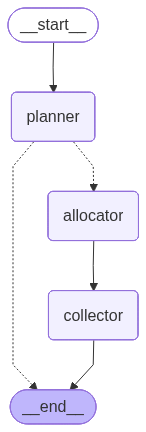

In [55]:
workflow = StateGraph(AgentState)

workflow.add_node("planner", planner_node)
workflow.add_node("allocator", allocator_node)
workflow.add_node("collector", collector_node)

# 순서 연결
workflow.set_entry_point("planner")

def check_complete(state: AgentState):
    if state['preferences'].is_complete:
        return "allocator"
    return END

workflow.add_conditional_edges(
    "planner",
    check_complete,
    {"allocator": "allocator", END: END}
)

workflow.add_edge("allocator", "collector")

workflow.add_edge("collector", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
# 그래프 그리기
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [56]:
import uuid
import json
from langchain_core.messages import HumanMessage

# --- [0] 설정 (Config) ---
# 실행할 때마다 새로운 세션을 원하면 thread_id를 바꾸세요.
THREAD_ID = str(uuid.uuid4()) # 매번 새로운 ID 생성 (테스트용)
# THREAD_ID = "user_test_1"   # 고정 ID (기억 유지 테스트용)

config = {"configurable": {"thread_id": THREAD_ID}}

def run_interactive_test():
    print(f"🚀 [Seoul Mate] 여행 코스 생성기 시작! (Session: {THREAD_ID})")
    print("🤖 Agent 1: 안녕하세요! 서울 여행 계획을 도와드릴게요. (종료: 'q')")
    
    while True:
        try:
            user_input = input("\n👤 유저: ")
            if user_input.lower() in ['q', 'quit', 'exit']:
                print("👋 프로그램을 종료합니다.")
                break
            
            inputs = {"messages": [HumanMessage(content=user_input)]}
            print("\n🔄 [Processing]...")
            
            # [핵심 수정 1] 전체 데이터를 모을 빈 그릇 생성
            accumulated_state = {} 
            
            for output in app.stream(inputs, config=config):
                for node_name, state_update in output.items():
                    print(f"   ✨ Finished Node: [{node_name}]")
                    
                    # [핵심 수정 2] 나오는 데이터 조각들을 계속 합칩니다.
                    # 이렇게 하면 preferences, strategy, candidates가 모두 모입니다.
                    accumulated_state.update(state_update)
                    
                    # (로그 출력 부분은 기존과 동일)
                    if node_name == "planner":
                        prefs = state_update['preferences']
                        if not prefs.is_complete:
                            print(f"      ❓ 질문: {prefs.missing_info_question}")
                        else:
                            print(f"      ✅ 정보 수집 완료! (지역: {prefs.target_area})")
                            
                    elif node_name == "allocator":
                        # strategy가 없을 수도 있으니 방어 코드
                        if 'strategy' in state_update:
                            print(f"      📊 전략 수립 완료! (총 {len(state_update['strategy'].allocations)}개 카테고리)")

                    elif node_name == "collector":
                         if 'candidates' in state_update:
                            print(f"      🎉 수집 완료! 총 {len(state_update['candidates'])}개의 장소 확보.")

            # [핵심 수정 3] 루프가 끝난 후, '모아둔 데이터(accumulated_state)'에서 꺼내옵니다.
            # collector 단계까지 갔다면 candidates가 존재함
            if 'candidates' in accumulated_state and accumulated_state['candidates']:
                print("\n🏁 [Process Completed] 모든 단계가 성공적으로 완료되었습니다!")
                
                # 1. Preferences 출력
                if 'preferences' in accumulated_state:
                    current_prefs = accumulated_state['preferences']
                    print(f"\n📦 [1] 최종 선호도 (Agent 1):")
                    print(json.dumps(current_prefs.model_dump(), indent=2, ensure_ascii=False))

                # 2. Strategy 출력
                if 'strategy' in accumulated_state:
                    current_strategy = accumulated_state['strategy']
                    print(f"\n📦 [2] 최종 전략 (Agent 2):")
                    print(json.dumps(current_strategy.model_dump(), indent=2, ensure_ascii=False))
                
                # 3. Candidates 출력
                # 주의: Pydantic V2이므로 .dict() 대신 .model_dump() 사용 권장
                print(f"\n📦 [3] 수집된 장소 리스트 (Agent 3) - 상위 5개만 표시:")
                candidates_data = [c.model_dump() for c in accumulated_state['candidates']]
                print(json.dumps(candidates_data[:5], indent=2, ensure_ascii=False))
                
                print(f"\n... 총 {len(candidates_data)}개 장소 데이터 확보됨.")
                print("\n(테스트 종료를 원하시면 'q'를, 추가 대화를 원하시면 계속 입력하세요)")

        except Exception as e:
            print(f"\n❌ Error 발생: {e}")
            import traceback
            traceback.print_exc()
            break

if __name__ == "__main__":
    run_interactive_test()

🚀 [Seoul Mate] 여행 코스 생성기 시작! (Session: cc4cedf2-d2a1-4712-a300-06e4775bd95f)
🤖 Agent 1: 안녕하세요! 서울 여행 계획을 도와드릴게요. (종료: 'q')

🔄 [Processing]...
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
   ✨ Finished Node: [planner]
      ❓ 질문: 여행 기간은 며칠 정도로 계획하고 계신가요?

🔄 [Processing]...
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
   ✨ Finished Node: [planner]
      ❓ 질문: 여행 강도는 어느 정도로 생각하고 계신가요? (예: 편안한 여행, 보통, 활동적인 여행)

🔄 [Processing]...
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
   ✨ Finished Node: [planner]
      ❓ 질문: 여행 강도는 어느 정도로 생각하고 계신가요? (예: 편안한 여행, 보통, 활동적인 여행)

🔄 [Processing]...
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
   ✨ Finished Node: [planner]
      ❓ 질문: 여행 강도는 어느 정도로 생각하고 계신가요? (예: 편안한 여행, 보통, 활동적인 여행)

🔄 [Processing]...
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
   ✨ Finished Node: [planner]
      ❓ 질문: 여행 동행자 분은 어떻게 되시나요?

🔄 [Processing]...
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
   ✨ Finished Node: [planner]
      ❓ 질문: 여행 동행자 분은 어떻게 되시나요?

🔄 [Processing]...
🤖 --- [Planner Node] 사용자 

In [25]:
# import os
# import requests
# import json
# from dotenv import load_dotenv

# # .env 파일이 있다면 로드 (없으면 무시)
# load_dotenv()

# def validate_kakao_api(query="종로 맛집", category_code="FD6"):
#     print(f"🚀 [Test] Kakao API 검증 시작... (검색어: {query})")

#     # 1. API 키 확인
#     # 환경변수에서 가져오거나, 여기에 직접 문자열로 넣어서 테스트하세요.
#     api_key = os.environ.get("KAKAO_REST_API_KEY") 
    
#     if not api_key:
#         print("❌ Error: 'KAKAO_REST_API_KEY'가 환경변수에 없습니다.")
#         print("   코드 내에 api_key 변수에 직접 키를 입력해서 테스트해보세요.")
#         return

#     # 2. 요청 준비
#     url = "https://dapi.kakao.com/v2/local/search/keyword.json"
#     headers = {
#         "Authorization": f"KakaoAK {api_key}" # 'KakaoAK ' 공백 필수!
#     }
#     params = {
#         "query": query,
#         "category_group_code": category_code,
#         "size": 3, # 3개만 테스트
#         "sort": "accuracy"
#     }

#     try:
#         # 3. API 호출
#         print(f"📡 Sending Request to {url}...")
#         response = requests.get(url, headers=headers, params=params)
        
#         # 4. 상태 코드 확인
#         status_code = response.status_code
#         if status_code == 200:
#             data = response.json()
#             documents = data.get("documents", [])
#             meta = data.get("meta", {})

#             print(f"\n✅ [Success] 성공적으로 데이터를 수신했습니다! (Total count: {meta.get('total_count')})")
#             print("-" * 50)
            
#             if not documents:
#                 print("⚠️ 경고: 호출은 성공했으나, 검색 결과가 0개입니다. 쿼리나 카테고리 코드를 확인하세요.")
            
#             # 5. 데이터 구조 확인 (Agent 3에서 쓸 필드들)
#             for idx, doc in enumerate(documents):
#                 print(f"[{idx+1}] {doc['place_name']}")
#                 print(f"    - 주소: {doc['road_address_name'] or doc['address_name']}")
#                 print(f"    - 카테고리: {doc['category_name']}")
#                 print(f"    - 코드: {doc['category_group_code']}")
#                 print(f"    - URL: {doc['place_url']}")
#                 print(f"    - 좌표: x(경도)={doc['x']}, y(위도)={doc['y']}")
#                 print("-" * 50)
                
#         elif status_code == 401:
#             print(f"\n❌ [Error 401] 인증 실패 (Unauthorized)")
#             print("   - API 키가 올바른지 확인하세요.")
#             print("   - 'REST API 키'를 사용했는지 확인하세요. (JavaScript 키 아님)")
#             print("   - 헤더 형식이 'KakaoAK {KEY}' 인지 확인하세요.")
            
#         elif status_code == 400:
#             print(f"\n❌ [Error 400] 잘못된 요청 (Bad Request)")
#             print("   - 쿼리 파라미터나 카테고리 코드가 올바른지 확인하세요.")
#             print(f"   - 응답 내용: {response.text}")
            
#         else:
#             print(f"\n❌ [Error {status_code}] 알 수 없는 오류 발생")
#             print(f"   - 응답 내용: {response.text}")

#     except Exception as e:
#         print(f"\n❌ [Exception] 요청 중 예외 발생: {e}")

# if __name__ == "__main__":
#     # 테스트 실행
#     # 1. 일반적인 맛집 검색
#     validate_kakao_api(query="익선동 파스타", category_code="FD6")
    
#     # 2. (선택사항) 주차장 검색 테스트
#     # validate_kakao_api(query="종로 공영 주차장", category_code="PK6")